## Step 1: Assign Country label to features.

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# --- Load the data ---
rain_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Rainf_tavg_data.csv")  # Sheet 1: rain points
lookup_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/country_latitude_longitude_area_lookup.csv")  # Sheet 2: country centroids

# --- Convert rain data to GeoDataFrame ---
rain_df['geometry'] = [Point(xy) for xy in zip(rain_df['longitude'], rain_df['latitude'])]
rain_gdf = gpd.GeoDataFrame(rain_df, geometry='geometry', crs='EPSG:4326')

# --- Convert country centroids to GeoDataFrame ---
lookup_df['geometry'] = [Point(xy) for xy in zip(lookup_df['longitude'], lookup_df['latitude'])]

# --- Convert to a projected CRS (e.g. World Mercator) before nearest join ---
projected_crs = "EPSG:3857"  # World Mercator (meters)

rain_gdf_proj = rain_gdf.to_crs(projected_crs)
lookup_gdf = gpd.GeoDataFrame(lookup_df, geometry='geometry', crs='EPSG:4326')

lookup_gdf_proj = lookup_gdf.to_crs(projected_crs)

# Now do the spatial join using projected coordinates
joined = gpd.sjoin_nearest(rain_gdf_proj, lookup_gdf_proj, how='left', distance_col='distance_to_centroid')

# Restore original CRS and drop geometry if needed
joined = joined.to_crs("EPSG:4326")  # optional if you're exporting lat/lon
result_df = joined.drop(columns='geometry')


# # --- Spatial Join: Assign country to each rain point based on nearest centroid ---
# # This assumes centroids are close enough — ideally replace this with polygons
# joined = gpd.sjoin_nearest(rain_gdf, lookup_gdf, how='left', distance_col='distance_to_centroid')

# # --- Optional: Drop geometry or filter columns ---
result_df = joined.drop(columns='geometry')

# Save or use result_df
result_df.to_csv("rain_data_with_country_labels.csv", index=False)

In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# --- Load the data ---
rain_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Rainf_tavg_data.csv")
lookup_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/country_latitude_longitude_area_lookup.csv")

# --- Convert rain data to GeoDataFrame ---
rain_df['geometry'] = [Point(xy) for xy in zip(rain_df['longitude'], rain_df['latitude'])]
rain_gdf = gpd.GeoDataFrame(rain_df, geometry='geometry', crs='EPSG:4326')

# --- Convert country centroids to GeoDataFrame ---
lookup_df['geometry'] = [Point(xy) for xy in zip(lookup_df['longitude'], lookup_df['latitude'])]
lookup_gdf = gpd.GeoDataFrame(lookup_df, geometry='geometry', crs='EPSG:4326')

# --- Project to a CRS in meters before nearest join ---
projected_crs = "EPSG:3857"
rain_gdf_proj = rain_gdf.to_crs(projected_crs)
lookup_gdf_proj = lookup_gdf.to_crs(projected_crs)

# --- Spatial Join: Assign country to each rain point based on nearest centroid ---
joined = gpd.sjoin_nearest(rain_gdf_proj, lookup_gdf_proj, how='left', distance_col='distance_to_centroid')

# --- Restore original CRS and drop geometry ---
joined = joined.to_crs("EPSG:4326")
result_df = joined.drop(columns='geometry')

# --- Save full rain data with country labels ---
result_df.to_csv("rain_data_with_country_labels.csv", index=False)

# ==============================================
# === Country-Year Rainfall Summary (Added) ===
# ==============================================

# Step 1: Define the monthly columns
monthly_columns = [f"Rainf_tavg_month_{i}" for i in range(1, 13)]

# Step 2: Group by country and year, compute monthly means
grouped = result_df.groupby(["country", "year"])[monthly_columns]
monthly_mean = grouped.mean().reset_index()

# Step 3: Add yearly features
monthly_mean["total_annual_rainfall"] = monthly_mean[monthly_columns].sum(axis=1)
monthly_mean["mean_monthly_rainfall"] = monthly_mean[monthly_columns].mean(axis=1)
monthly_mean["std_monthly_rainfall"] = monthly_mean[monthly_columns].std(axis=1)
monthly_mean["max_monthly_rainfall"] = monthly_mean[monthly_columns].max(axis=1)
monthly_mean["rainfall_peak_month"] = (
    monthly_mean[monthly_columns]
    .idxmax(axis=1)
    .str.extract("(\d+)$")[0]
    .astype(int)
)

# Step 4: Save summary to same CSV file (as second sheet or separate file if needed)
monthly_mean.to_csv("rain_summary_by_country_year.csv", index=False)

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Load datasets ---
rain_df = pd.read_csv("rain_summary_by_country_year.csv")
yield_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Yield_and_Production_data.csv")

# --- Pivot yield_df: group by Country, Year, Item ---
pivot_df = yield_df.pivot_table(
    index=["Country", "Year", "Item"],
    columns="Element",
    values="Value"
).reset_index()
pivot_df.columns.name = None
pivot_df.rename(columns={"Country": "country", "Year": "year"}, inplace=True)

# --- Merge on country, year, and item ---
merged_df = pd.merge(rain_df, pivot_df, on=["country", "year"], how="inner")

# ================================
# 🧹 Drop rows with bad Production
# ================================
merged_df = merged_df.dropna(subset=["Production"])  # remove NaNs
merged_df = merged_df[merged_df["Production"] > 0]   # remove Production = 0

# --- Split the data into Train (70%) and Temp (30%) ---
train_df, temp_df = train_test_split(merged_df, test_size=0.3, random_state=42)

# --- Split Temp into Validation (15%) and Test (15%) ---
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# --- Save raw splits ---
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

# ==============================
# 🔄 Normalize Numerical Columns
# ==============================

# Identify columns to scale (exclude identifiers + targets)
exclude_cols = ['country', 'year', 'Item', 'Yield', 'Production']
features_to_scale = [col for col in train_df.columns if col not in exclude_cols]

# Initialize scaler
scaler = StandardScaler()

train_scaled = train_df.copy()
val_scaled = val_df.copy()
test_scaled = test_df.copy()

train_scaled[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
val_scaled[features_to_scale] = scaler.transform(val_df[features_to_scale])
test_scaled[features_to_scale] = scaler.transform(test_df[features_to_scale])

# --- Save scaled datasets ---
train_scaled.to_csv("train_data_scaled.csv", index=False)
val_scaled.to_csv("val_data_scaled.csv", index=False)
test_scaled.to_csv("test_data_scaled.csv", index=False)

print("✅ Data cleaned, merged (with Item), split, normalized, and exported.")
print(f"Train: train_data.csv / train_data_scaled.csv")
print(f"Validation: val_data.csv / val_data_scaled.csv")
print(f"Test: test_data.csv / test_data_scaled.csv")

✅ Data cleaned, merged (with Item), split, normalized, and exported.
Train: train_data.csv / train_data_scaled.csv
Validation: val_data.csv / val_data_scaled.csv
Test: test_data.csv / test_data_scaled.csv


Epoch 0 | Train Loss: 0.6659 | Val Loss: 0.4157
Epoch 10 | Train Loss: 0.3759 | Val Loss: 0.3587
Epoch 20 | Train Loss: 0.3345 | Val Loss: 0.3360
Epoch 30 | Train Loss: 0.3029 | Val Loss: 0.3075
Epoch 40 | Train Loss: 0.2706 | Val Loss: 0.2935


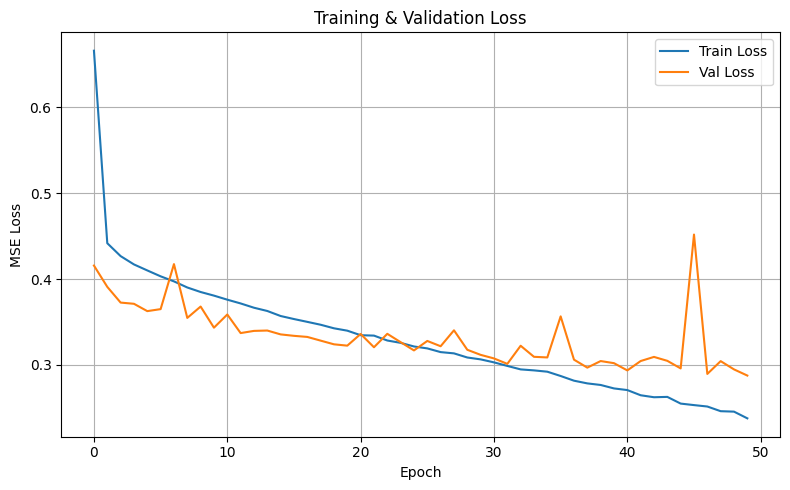


✅ Test RMSE: 8771.45
✅ Test R² Score: 0.6290
✅ Best model saved to: best_mlp_model.pth


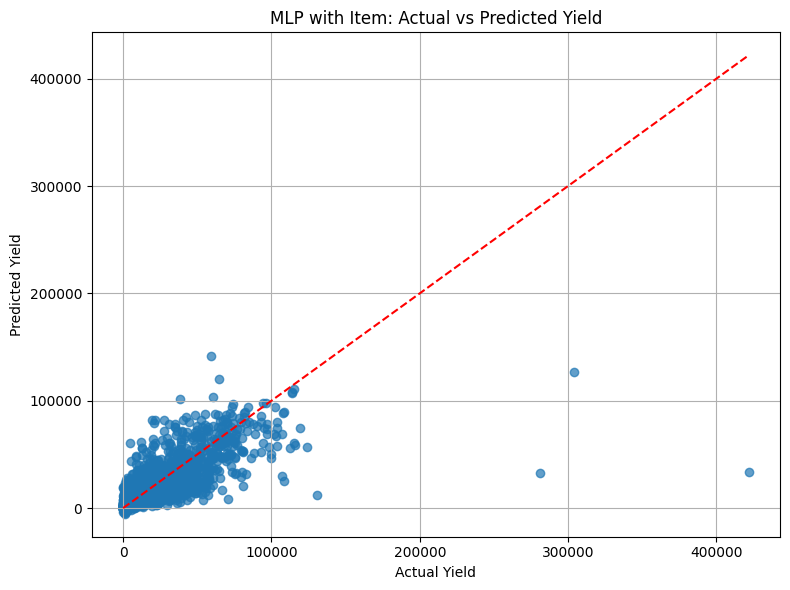

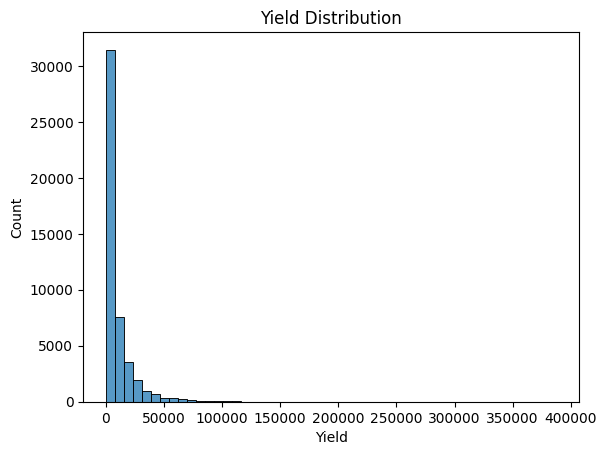

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os
import seaborn as sns

# ============================
# 📥 Load and prepare data
# ============================
target_col = 'Yield'  # or 'Production' based on your requirement
train_df = pd.read_csv("train_data_scaled.csv")
val_df = pd.read_csv("val_data_scaled.csv")
test_df = pd.read_csv("test_data_scaled.csv")

# --- Drop rows with missing or zero Production again for safety ---
train_df = train_df[train_df[target_col] > 0]
val_df = val_df[val_df[target_col] > 0]
test_df = test_df[test_df[target_col] > 0]

# --- One-hot encode 'Item' and align all sets ---
train_df = pd.get_dummies(train_df, columns=["Item"])
val_df = pd.get_dummies(val_df, columns=["Item"])
test_df = pd.get_dummies(test_df, columns=["Item"])

# Align one-hot columns across splits
val_df = val_df.reindex(columns=train_df.columns, fill_value=0)
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

# --- Define input features ---
exclude = ['country', 'year', 'Yield', 'Production']
features = [col for col in train_df.columns if col not in exclude]

# --- Extract X and y ---
# X_train = train_df[features].values
X_train = train_df[features].astype(float).values
X_val = val_df[features].astype(float).values
X_test = test_df[features].astype(float).values

y_train = train_df[[target_col]].values
#X_val = val_df[features].values
y_val = val_df[[target_col]].values
#X_test = test_df[features].values
y_test = test_df[[target_col]].values

# --- Normalize target (Production) ---
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

# --- Convert to tensors ---
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=16, shuffle=True)

# ============================
# 🔧 Simple MLP Model
# ============================
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # self.net = nn.Sequential(
        #     nn.Linear(input_dim, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, 1)
        # )
        # self.net = nn.Sequential(
        #     nn.Linear(input_dim, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, 1)
        # )
        # self.net = nn.Sequential(
        #     nn.Linear(input_dim, 64),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),
        #     nn.Linear(64, 32),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),
        #     nn.Linear(32, 1)
        # )
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = SimpleMLP(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ============================
# 🚀 Training Loop with Saving Best Model
# ============================
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_path = "best_mlp_model.pth"

for epoch in range(50):
    model.train()
    batch_losses = []
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    train_losses.append(np.mean(batch_losses))

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss = criterion(val_preds, y_val_t).item()
        val_losses.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_loss:.4f}")

# ============================
# 📊 Plot Loss Curves
# ============================
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================
# 🧪 Evaluate Best Model on Test Set
# ============================
# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

with torch.no_grad():
    test_preds_scaled = model(X_test_t).numpy()
    test_preds = y_scaler.inverse_transform(test_preds_scaled).flatten()
    y_test_flat = y_test.flatten()

# --- Filter valid predictions ---
results_df = pd.DataFrame({
    "y_true": y_test_flat,
    "y_pred": test_preds
}).dropna()

mse = mean_squared_error(results_df["y_true"], results_df["y_pred"])
rmse = np.sqrt(mse)
r2 = r2_score(results_df["y_true"], results_df["y_pred"])

print(f"\n✅ Test RMSE: {rmse:.2f}")
print(f"✅ Test R² Score: {r2:.4f}")
print(f"✅ Best model saved to: {best_model_path}")

# ============================
# 📈 Plot Predictions vs Actual
# ============================
plt.figure(figsize=(8, 6))  # 🔧 Wider and taller plot
plt.scatter(results_df["y_true"], results_df["y_pred"], alpha=0.7)
plt.plot([results_df["y_true"].min(), results_df["y_true"].max()],
         [results_df["y_true"].min(), results_df["y_true"].max()], 'r--')

# ✅ Corrected axis labels
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")

# ✅ Better plot title
plt.title("MLP with Item: Actual vs Predicted Yield")

plt.grid(True)
plt.tight_layout()
plt.show()


sns.histplot(train_df['Yield'], bins=50)
plt.title("Yield Distribution")
plt.show()